In [ ]:
!pip install matplotlib


In [ ]:
!pip install torch torchaudio transformers datasets soundfile librosa scikit-learn pandas matplotlib tqdm


In [ ]:
# Google Colab Drive mounting - not needed in VS Code
# from google.colab import drive
# drive.mount('/content/drive')

# In VS Code, you'll use local file paths instead
print("Running in VS Code - using local file paths")

Running in VS Code - using local file paths


In [ ]:
!python -m torch.utils.collect_env


/home/staru/anaconda3/envs/wave2vec/lib/python3.10/runpy.py:126: RuntimeWarning: 'torch.utils.collect_env' found in sys.modules after import of package 'torch.utils', but prior to execution of 'torch.utils.collect_env'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
PyTorch version: 2.8.0+cu128
Is debug build: False
CUDA used to build PyTorch: 12.8
ROCM used to build PyTorch: N/A

OS: Ubuntu 24.04.2 LTS (x86_64)
GCC version: (Ubuntu 13.3.0-6ubuntu2~24.04) 13.3.0
Clang version: Could not collect
CMake version: version 3.28.3
Libc version: glibc-2.39

Python version: 3.10.18 | packaged by conda-forge | (main, Jun  4 2025, 14:45:41) [GCC 13.3.0] (64-bit runtime)
Python platform: Linux-6.14.0-37-generic-x86_64-with-glibc2.39
Is CUDA available: True
CUDA runtime version: 12.0.140
CUDA_MODULE_LOADING set to: LAZY
GPU models and configuration: GPU 0: NVIDIA RTX A5500
Nvidia driver version: 580.65.06
cuDNN version: Could not collect
HIP runtime version: N/A
MIOpen runti

In [ ]:
# %%
# Block 1 — Setup & Imports
# Run this first. Assumes GPU (CUDA) is available.
import os
import random
import math
from pathlib import Path
import time

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.nn.utils import clip_grad_norm_

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Transformers Wav2Vec2
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification, get_linear_schedule_with_warmup

print('Torch version:', torch.__version__)
print('CUDA available:', torch.cuda.is_available())




Torch version: 2.8.0+cu128
CUDA available: True


In [ ]:
# %%
# Block 2 — Reproducibility and device
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)



Using device: cuda


In [ ]:
# %% Block 3 — Paths and user settings
# Update DATA_PATH to point to your local audio data folder
DATA_PATH = r"/home/staru/audio_aug/aug_bandpass_audio"  # <-- Update this with your actual local path
OUTPUT_DIR = "./wav2vec2_finetune"
os.makedirs(OUTPUT_DIR, exist_ok=True)

NUM_EPOCHS = 50
BATCH_SIZE = 8
LR = 2e-5
WEIGHT_DECAY = 0.01
MAX_GRAD_NORM = 1.0
WARMUP_STEPS = 200

In [ ]:
# %%
# Block 5 — Dataset class
# This class reads audio files and returns processed tensors for Wav2Vec2
import soundfile as sf
import librosa

class AudioDataset(Dataset):
    def __init__(self, dataframe, audio_root, feature_extractor, label2id, sampling_rate=16000, max_duration=None):
        self.df = dataframe.reset_index(drop=True)
        self.audio_root = Path(audio_root)
        self.feature_extractor = feature_extractor
        self.label2id = label2id
        self.sr = sampling_rate
        self.max_duration = max_duration  # seconds, optional

    def __len__(self):
        return len(self.df)

    def load_audio(self, path):
        # Use librosa to ensure consistent sampling rate
        x, sr = librosa.load(path, sr=self.sr)
        if self.max_duration is not None:
            max_len = int(self.max_duration * self.sr)
            if len(x) > max_len:
                x = x[:max_len]
        return x

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Reconstruct full path: audio_root / emotion_folder / filename
        audio_path = self.audio_root / row['Emotion'] / row['Path']
        speech = self.load_audio(str(audio_path))
        # feature_extractor expects a list of 1-D arrays
        inputs = self.feature_extractor(speech, sampling_rate=self.sr, return_tensors='pt')
        input_values = inputs.input_values.squeeze(0)  # (seq_len,)
        label = self.label2id[row['Emotion']]
        return {
            'input_values': input_values,
            'labels': torch.tensor(label, dtype=torch.long)
        }



In [ ]:
# %%
# Block 6 — Collate function for DataLoader
def collate_fn(batch):
    input_values = [b['input_values'] for b in batch]
    labels = torch.stack([b['labels'] for b in batch])
    # pad inputs
    batch_inputs = feature_extractor.pad({'input_values': input_values}, return_tensors='pt')
    # returns dict with 'input_values' and 'attention_mask'
    batch_inputs['labels'] = labels
    return batch_inputs



In [ ]:
# %%
# Block 7 — Automatically create dataframe from folder structure
emotions = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad']
data = []

# Validate DATA_PATH exists
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"DATA_PATH does not exist: {DATA_PATH}")

for emotion in emotions:
    folder = os.path.join(DATA_PATH, emotion)
    if not os.path.exists(folder):
        print(f"Warning: Emotion folder not found: {folder}")
        continue
    for fname in os.listdir(folder):
        if fname.endswith(".wav"):
            data.append({
                'Path': fname,  # Store only filename, not full path
                'Emotion': emotion
            })

full_df = pd.DataFrame(data)
print("Total samples:", len(full_df))
print(full_df.head())

# Split into train/test
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(
    full_df, test_size=0.2, stratify=full_df['Emotion'], random_state=42
)

print("Train samples:", len(train_df))
print("Validation samples:", len(val_df))


Total samples: 8100
                                Path Emotion
0  A12_PB_A_S12_band_pass_filter.wav   Anger
1   A9_PB_A_S12_band_pass_filter.wav   Anger
2    A1_PB_A_S8_band_pass_filter.wav   Anger
3   A9_PB_A_S13_band_pass_filter.wav   Anger
4   A12_HI_A_S5_band_pass_filter.wav   Anger
Train samples: 6480
Validation samples: 1620


Please update `DATA_PATH` in Block 3 to point to the correct local folder where your `aug_bandpass_audio` directory is located. The current path is set to `/home/staru/audio_aug/aug_bandpass_audio`.

In [ ]:
# %% Block 4 — Model and Label Setup
MODEL_NAME = "facebook/wav2vec2-base"
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(MODEL_NAME)

LABELS = emotions # Using the emotions detected in Block 7
label2id = {label: i for i, label in enumerate(LABELS)}
id2label = {i: label for i, label in enumerate(LABELS)}

print("Labels:", LABELS)
print("Label to ID mapping:", label2id)
print("ID to Label mapping:", id2label)

Labels: ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad']
Label to ID mapping: {'Anger': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5}
ID to Label mapping: {0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad'}


In [ ]:

# %%
# Block 8 — Create datasets and loaders
# Note: num_workers=0 is recommended for Windows to avoid multiprocessing issues
train_dataset = AudioDataset(train_df, DATA_PATH, feature_extractor, label2id, sampling_rate=16000)
val_dataset = AudioDataset(val_df, DATA_PATH, feature_extractor, label2id, sampling_rate=16000)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0)


In [ ]:
# %%
# Block 9 — Model initialization and head configuration
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(LABELS),
    label2id=label2id,
    id2label=id2label,
    problem_type='single_label_classification'
)

# Freeze feature extractor layers initially (optional, helps stability)
for param in model.wav2vec2.feature_extractor.parameters():
    param.requires_grad = False

model.to(DEVICE)

/home/staru/anaconda3/envs/wave2vec/lib/python3.10/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRA

Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)


In [ ]:

# %%
# Block 10 — Optimizer and scheduler
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR, weight_decay=WEIGHT_DECAY)
# total training steps
total_steps = len(train_loader) * NUM_EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=total_steps)



In [ ]:
# %%
# Block 11 — Training & evaluation helper functions

def train_one_epoch(model, dataloader, optimizer, scheduler, device, epoch):
    model.train()
    losses = []
    all_preds = []
    all_labels = []
    loop = tqdm(dataloader, desc=f"Train Epoch {epoch}")
    for batch in loop:
        input_values = batch['input_values'].to(device)
        attention_mask = batch.get('attention_mask')
        if attention_mask is not None:
            attention_mask = attention_mask.to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_values, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
        optimizer.step()
        scheduler.step()

        losses.append(loss.item())
        preds = torch.argmax(logits, dim=-1).detach().cpu().numpy()
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.detach().cpu().numpy().tolist())

        loop.set_postfix({'loss': np.mean(losses)})

    acc = accuracy_score(all_labels, all_preds)
    return np.mean(losses), acc


def evaluate(model, dataloader, device):
    model.eval()
    losses = []
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Evaluating'):
            input_values = batch['input_values'].to(device)
            attention_mask = batch.get('attention_mask')
            if attention_mask is not None:
                attention_mask = attention_mask.to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_values, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            losses.append(loss.item())
            preds = torch.argmax(logits, dim=-1).detach().cpu().numpy()
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.detach().cpu().numpy().tolist())

    acc = accuracy_score(all_labels, all_preds)
    return np.mean(losses), acc, all_labels, all_preds



In [ ]:
# %%
# Block 12 — Training loop with early stopping and unfreezing strategy
best_val_acc = 0.0
patience = 5  # Stop if no improvement for 5 consecutive epochs
patience_counter = 0
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(1, NUM_EPOCHS+1):
    # Unfreeze after a couple epochs to fine-tune feature extractor
    if epoch == 3:
        for param in model.wav2vec2.feature_extractor.parameters():
            param.requires_grad = True
        print('Unfroze feature extractor parameters')

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, scheduler, DEVICE, epoch)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, DEVICE)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch}: Train loss {train_loss:.4f}, Train acc {train_acc:.4f} | Val loss {val_loss:.4f}, Val acc {val_acc:.4f}")

    # Save best model and reset patience counter if validation improves
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0  # Reset counter
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'best_model.pth'))
        print('Saved best model')
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter}/{patience} epochs")
        if patience_counter >= patience:
            print(f"Early stopping triggered! No improvement for {patience} epochs.")
            break



Evaluating: 100%|██████████| 203/203 [00:20<00:00, 10.05it/s]



Epoch 1: Train loss 1.3733, Train acc 0.4571 | Val loss 1.0514, Val acc 0.6086
Saved best model
Saved best model


Evaluating: 100%|██████████| 203/203 [00:11<00:00, 18.12it/s]



Epoch 2: Train loss 0.9190, Train acc 0.6696 | Val loss 0.9191, Val acc 0.6716
Saved best model
Unfroze feature extractor parameters
Saved best model
Unfroze feature extractor parameters


Evaluating: 100%|██████████| 203/203 [00:11<00:00, 17.84it/s]



Epoch 3: Train loss 0.5958, Train acc 0.8026 | Val loss 0.7865, Val acc 0.7389
Saved best model
Saved best model


Evaluating: 100%|██████████| 203/203 [00:11<00:00, 18.09it/s]



Epoch 4: Train loss 0.5159, Train acc 0.8324 | Val loss 0.8353, Val acc 0.7407
Saved best model
Saved best model


Evaluating: 100%|██████████| 203/203 [00:11<00:00, 18.03it/s]



Epoch 5: Train loss 0.4843, Train acc 0.8475 | Val loss 0.7963, Val acc 0.7691
Saved best model
Saved best model


Evaluating: 100%|██████████| 203/203 [00:11<00:00, 18.06it/s]



Epoch 6: Train loss 0.4551, Train acc 0.8647 | Val loss 0.8477, Val acc 0.7802
Saved best model
Saved best model


Evaluating: 100%|██████████| 203/203 [00:11<00:00, 17.74it/s]



Epoch 7: Train loss 0.4335, Train acc 0.8807 | Val loss 0.9268, Val acc 0.7833
Saved best model
Saved best model


Evaluating: 100%|██████████| 203/203 [00:11<00:00, 17.88it/s]


Epoch 8: Train loss 0.4219, Train acc 0.8918 | Val loss 0.9134, Val acc 0.7827


Evaluating: 100%|██████████| 203/203 [00:11<00:00, 18.02it/s]


Epoch 9: Train loss 0.3772, Train acc 0.9091 | Val loss 1.2957, Val acc 0.7833


Evaluating: 100%|██████████| 203/203 [00:11<00:00, 17.87it/s]



Epoch 10: Train loss 0.3335, Train acc 0.9276 | Val loss 1.0323, Val acc 0.8265
Saved best model
Saved best model


Evaluating: 100%|██████████| 203/203 [00:11<00:00, 18.11it/s]


Epoch 11: Train loss 0.3388, Train acc 0.9302 | Val loss 1.0318, Val acc 0.8191


Evaluating: 100%|██████████| 203/203 [00:11<00:00, 18.07it/s]


Epoch 12: Train loss 0.2695, Train acc 0.9460 | Val loss 1.1830, Val acc 0.8080


Evaluating: 100%|██████████| 203/203 [00:11<00:00, 18.08it/s]


Epoch 13: Train loss 0.2414, Train acc 0.9528 | Val loss 1.0496, Val acc 0.8259


Evaluating: 100%|██████████| 203/203 [00:11<00:00, 18.13it/s]



Epoch 14: Train loss 0.2283, Train acc 0.9580 | Val loss 1.1874, Val acc 0.8321
Saved best model
Saved best model


Evaluating: 100%|██████████| 203/203 [00:11<00:00, 18.27it/s]


Epoch 15: Train loss 0.1915, Train acc 0.9671 | Val loss 1.3748, Val acc 0.8167


Evaluating: 100%|██████████| 203/203 [00:11<00:00, 18.00it/s]



Epoch 16: Train loss 0.2108, Train acc 0.9628 | Val loss 1.2994, Val acc 0.8346
Saved best model
Saved best model


Evaluating: 100%|██████████| 203/203 [00:11<00:00, 18.12it/s]


Epoch 17: Train loss 0.1831, Train acc 0.9674 | Val loss 1.2581, Val acc 0.8272


Evaluating: 100%|██████████| 203/203 [00:11<00:00, 18.16it/s]


Epoch 18: Train loss 0.1850, Train acc 0.9681 | Val loss 1.3551, Val acc 0.8216


Evaluating: 100%|██████████| 203/203 [00:11<00:00, 17.87it/s]


Epoch 19: Train loss 0.1566, Train acc 0.9742 | Val loss 1.6485, Val acc 0.8019


Evaluating: 100%|██████████| 203/203 [00:11<00:00, 17.93it/s]


Epoch 20: Train loss 0.1304, Train acc 0.9775 | Val loss 1.4997, Val acc 0.8241


Evaluating: 100%|██████████| 203/203 [00:11<00:00, 17.91it/s]


Epoch 21: Train loss 0.1160, Train acc 0.9821 | Val loss 1.4185, Val acc 0.8272


Evaluating: 100%|██████████| 203/203 [00:11<00:00, 18.15it/s]


Epoch 22: Train loss 0.1271, Train acc 0.9802 | Val loss 1.5260, Val acc 0.8179


Evaluating: 100%|██████████| 203/203 [00:11<00:00, 18.07it/s]



Epoch 23: Train loss 0.1199, Train acc 0.9813 | Val loss 1.4074, Val acc 0.8377
Saved best model
Saved best model


Evaluating: 100%|██████████| 203/203 [00:11<00:00, 18.16it/s]


Epoch 24: Train loss 0.1131, Train acc 0.9819 | Val loss 1.5122, Val acc 0.8284


Evaluating: 100%|██████████| 203/203 [00:11<00:00, 18.10it/s]



Epoch 25: Train loss 0.0836, Train acc 0.9867 | Val loss 1.3639, Val acc 0.8389
Saved best model
Saved best model


Evaluating: 100%|██████████| 203/203 [00:11<00:00, 18.20it/s]


Epoch 26: Train loss 0.1042, Train acc 0.9841 | Val loss 1.4415, Val acc 0.8346


Evaluating: 100%|██████████| 203/203 [00:11<00:00, 18.06it/s]


Epoch 27: Train loss 0.0888, Train acc 0.9866 | Val loss 1.5751, Val acc 0.8265


Evaluating: 100%|██████████| 203/203 [00:11<00:00, 17.92it/s]


Epoch 28: Train loss 0.0691, Train acc 0.9892 | Val loss 1.5476, Val acc 0.8352


Evaluating: 100%|██████████| 203/203 [00:11<00:00, 18.08it/s]



Epoch 29: Train loss 0.0691, Train acc 0.9892 | Val loss 1.4185, Val acc 0.8500
Saved best model
Saved best model


Evaluating: 100%|██████████| 203/203 [00:21<00:00,  9.48it/s]


Epoch 30: Train loss 0.0594, Train acc 0.9904 | Val loss 1.6108, Val acc 0.8321


Evaluating: 100%|██████████| 203/203 [00:21<00:00,  9.44it/s]


Epoch 31: Train loss 0.0699, Train acc 0.9892 | Val loss 1.5477, Val acc 0.8340


Evaluating: 100%|██████████| 203/203 [00:21<00:00,  9.51it/s]


Epoch 32: Train loss 0.0568, Train acc 0.9910 | Val loss 1.8615, Val acc 0.8167


Evaluating: 100%|██████████| 203/203 [00:11<00:00, 18.20it/s]


Epoch 33: Train loss 0.0468, Train acc 0.9929 | Val loss 1.5381, Val acc 0.8420


Evaluating: 100%|██████████| 203/203 [00:11<00:00, 18.11it/s]


Epoch 34: Train loss 0.0416, Train acc 0.9944 | Val loss 1.5261, Val acc 0.8444


Evaluating: 100%|██████████| 203/203 [00:11<00:00, 18.12it/s]


Epoch 35: Train loss 0.0534, Train acc 0.9917 | Val loss 1.5624, Val acc 0.8414


Evaluating: 100%|██████████| 203/203 [00:11<00:00, 17.99it/s]



Epoch 36: Train loss 0.0364, Train acc 0.9940 | Val loss 1.4378, Val acc 0.8568
Saved best model
Saved best model


Evaluating: 100%|██████████| 203/203 [00:10<00:00, 19.48it/s]


Epoch 37: Train loss 0.0242, Train acc 0.9966 | Val loss 1.5788, Val acc 0.8475


Evaluating: 100%|██████████| 203/203 [00:11<00:00, 18.38it/s]


Epoch 38: Train loss 0.0310, Train acc 0.9957 | Val loss 1.5938, Val acc 0.8395


Evaluating: 100%|██████████| 203/203 [00:10<00:00, 19.27it/s]



Epoch 39: Train loss 0.0317, Train acc 0.9960 | Val loss 1.4801, Val acc 0.8580
Saved best model
Saved best model


Evaluating: 100%|██████████| 203/203 [00:10<00:00, 19.40it/s]


Epoch 40: Train loss 0.0210, Train acc 0.9974 | Val loss 1.5061, Val acc 0.8556


Evaluating: 100%|██████████| 203/203 [00:10<00:00, 19.12it/s]


Epoch 41: Train loss 0.0276, Train acc 0.9957 | Val loss 1.5500, Val acc 0.8525


Evaluating: 100%|██████████| 203/203 [00:10<00:00, 19.55it/s]


Epoch 42: Train loss 0.0255, Train acc 0.9965 | Val loss 1.4883, Val acc 0.8562


Evaluating: 100%|██████████| 203/203 [00:10<00:00, 18.94it/s]


Epoch 43: Train loss 0.0238, Train acc 0.9961 | Val loss 1.6613, Val acc 0.8420


Evaluating: 100%|██████████| 203/203 [00:10<00:00, 19.50it/s]


Epoch 44: Train loss 0.0111, Train acc 0.9983 | Val loss 1.4073, Val acc 0.8580


Evaluating: 100%|██████████| 203/203 [00:10<00:00, 19.40it/s]



Epoch 45: Train loss 0.0152, Train acc 0.9980 | Val loss 1.4533, Val acc 0.8617
Saved best model
Saved best model


Evaluating: 100%|██████████| 203/203 [00:10<00:00, 19.56it/s]


Epoch 46: Train loss 0.0125, Train acc 0.9985 | Val loss 1.4460, Val acc 0.8580


Evaluating: 100%|██████████| 203/203 [00:10<00:00, 18.82it/s]


Epoch 47: Train loss 0.0078, Train acc 0.9988 | Val loss 1.4545, Val acc 0.8574


Evaluating: 100%|██████████| 203/203 [00:11<00:00, 18.01it/s]


Epoch 48: Train loss 0.0099, Train acc 0.9985 | Val loss 1.4519, Val acc 0.8586


Evaluating: 100%|██████████| 203/203 [00:11<00:00, 18.04it/s]


Epoch 49: Train loss 0.0076, Train acc 0.9991 | Val loss 1.4792, Val acc 0.8568


Evaluating: 100%|██████████| 203/203 [00:11<00:00, 17.91it/s]

Epoch 50: Train loss 0.0092, Train acc 0.9989 | Val loss 1.4434, Val acc 0.8605


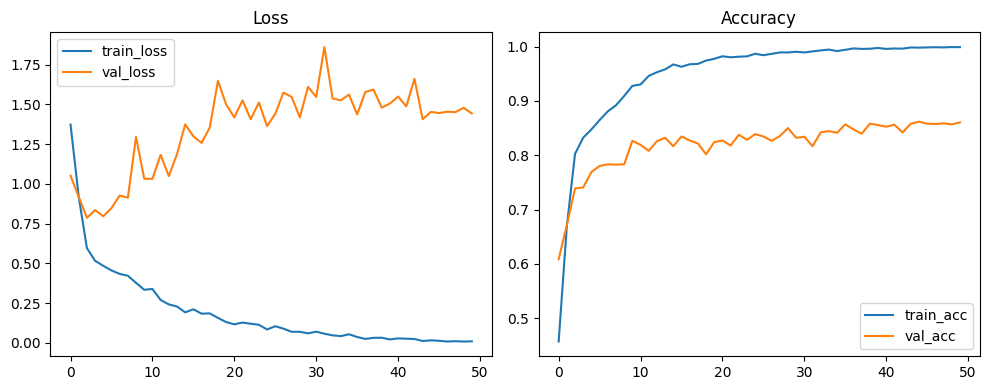

In [ ]:
# %%
# Block 13 — Plotting training curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history['train_acc'], label='train_acc')
plt.plot(history['val_acc'], label='val_acc')
plt.legend(); plt.title('Accuracy')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'training_curves.png'))
plt.show()



Evaluating: 100%|██████████| 203/203 [00:11<00:00, 18.06it/s]



Val accuracy: 0.8617283950617284
Confusion Matrix:
 [[257   3   1   9   0   0]
 [  5 197   6  18  34  10]
 [  1   5 250   2   0  12]
 [  6  10   3 215  24  12]
 [  0   7   0   8 247   8]
 [  0   9   7   9  15 230]]


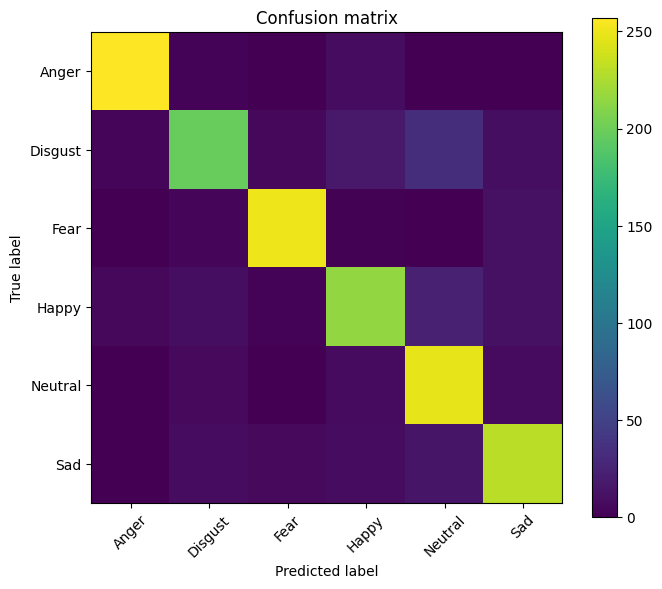


Classification Report:

              precision    recall  f1-score   support

       Anger       0.96      0.95      0.95       270
     Disgust       0.85      0.73      0.79       270
        Fear       0.94      0.93      0.93       270
       Happy       0.82      0.80      0.81       270
     Neutral       0.77      0.91      0.84       270
         Sad       0.85      0.85      0.85       270

    accuracy                           0.86      1620
   macro avg       0.86      0.86      0.86      1620
weighted avg       0.86      0.86      0.86      1620


Notebook ready. Update DATA_CSV and AUDIO_ROOT paths at the top and run the cells block-by-block.
              precision    recall  f1-score   support

       Anger       0.96      0.95      0.95       270
     Disgust       0.85      0.73      0.79       270
        Fear       0.94      0.93      0.93       270
       Happy       0.82      0.80      0.81       270
     Neutral       0.77      0.91      0.84       270
        

In [ ]:
# %%
# Block 14 — Confusion matrix and classification report on validation set
# Load best model weights
model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'best_model.pth')))
model.to(DEVICE)

val_loss, val_acc, y_true, y_pred = evaluate(model, val_loader, DEVICE)
print('Val accuracy:', val_acc)

cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:\n', cm)

plt.figure(figsize=(7,6))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion matrix')
plt.colorbar()
plt.xticks(np.arange(len(LABELS)), LABELS, rotation=45)
plt.yticks(np.arange(len(LABELS)), LABELS)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'))
plt.show()

print('\nClassification Report:\n')
print(classification_report(y_true, y_pred, target_names=LABELS))

# %%
# Block 15 — Tips and next steps (non-executable comments)
# 1) If you have class imbalance, use class weights in the loss or oversample minority classes.
# 2) Try data augmentation (time-stretching, pitch shift, additive noise) carefully.
# 3) Experiment with learning rate (1e-5 to 5e-5) and batch size (GPU memory permitting).
# 4) If your dataset is small, keep the feature extractor frozen longer and train only the classification head first.
# 5) Consider using gradient accumulation if batch size is limited by memory.
# 6) For long audio, consider truncation or sliding-window inference and majority-vote.

# Save the final training history
pd.DataFrame(history).to_csv(os.path.join(OUTPUT_DIR, 'training_history.csv'), index=False)

print('\nNotebook ready. Update DATA_CSV and AUDIO_ROOT paths at the top and run the cells block-by-block.')


In [ ]:
import os
import torch
import librosa
import numpy as np
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification

# Define the path where the full model will be saved for easier inference
FULL_MODEL_SAVE_DIR = os.path.join(OUTPUT_DIR, 'finetuned_wav2vec2_model')

# --- Script to save the FULL trained model (Run this AFTER training in Block 12 is complete) ---
# The training loop in Block 12 saves only the model's state_dict ('best_model.pth').
# For convenient loading and inference, it's best to save the entire model and its configuration
# using `save_pretrained()`. Run this block ONCE after your training in Block 12 has finished
# and the 'best_model.pth' file has been created.
print("--- Model Saving for Inference ---")
if os.path.exists(os.path.join(OUTPUT_DIR, 'best_model.pth')):
    print(f"Found 'best_model.pth'. Loading state_dict to save full model to '{FULL_MODEL_SAVE_DIR}'...")
    try:
        # Re-initialize the model architecture (same as in Block 9)
        model_to_save = Wav2Vec2ForSequenceClassification.from_pretrained(
            MODEL_NAME,
            num_labels=len(LABELS),
            label2id=label2id,
            id2label=id2label,
            problem_type='single_label_classification'
        )
        model_to_save.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'best_model.pth'), map_location=DEVICE))
        model_to_save.to(DEVICE)
        model_to_save.eval()

        # Create directory if it doesn't exist
        os.makedirs(FULL_MODEL_SAVE_DIR, exist_ok=True)
        # Save the full model and feature extractor (which also saves config, vocab, etc.)
        model_to_save.save_pretrained(FULL_MODEL_SAVE_DIR)
        feature_extractor.save_pretrained(FULL_MODEL_SAVE_DIR)
        print(f"Full model and feature extractor saved successfully to '{FULL_MODEL_SAVE_DIR}'.")
    except Exception as e:
        print(f"Could not save full model from state_dict. Error: {e}")
        print("Please ensure 'best_model.pth' exists and the model architecture is consistent.")
else:
    print(f"Skipping full model save: '{os.path.join(OUTPUT_DIR, 'best_model.pth')}' not found. Please run training (Block 12) first.")

print("\n--- Inference Script ---")

# Load the feature extractor and model for inference from the saved full model directory
# This assumes the full model was saved using model.save_pretrained() and feature_extractor.save_pretrained()
inference_model = None
inference_feature_extractor_obj = None # Avoid name clash with global feature_extractor

try:
    print(f"Attempting to load model and feature extractor from '{FULL_MODEL_SAVE_DIR}' for inference...")
    inference_feature_extractor_obj = Wav2Vec2FeatureExtractor.from_pretrained(FULL_MODEL_SAVE_DIR)
    inference_model = Wav2Vec2ForSequenceClassification.from_pretrained(FULL_MODEL_SAVE_DIR)
    inference_model.to(DEVICE)
    inference_model.eval()
    print("Model and feature extractor loaded successfully for inference.")
except Exception as e:
    print(f"Could not load full model from '{FULL_MODEL_SAVE_DIR}'. Error: {e}")
    print("Ensure the full model saving script above was run after training.")
    print("Proceeding with fallback: attempting to re-initialize model and load 'best_model.pth' state_dict...")
    try:
        inference_model = Wav2Vec2ForSequenceClassification.from_pretrained(
            MODEL_NAME,
            num_labels=len(LABELS),
            label2id=label2id,
            id2label=id2label,
            problem_type='single_label_classification'
        )
        inference_model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'best_model.pth'), map_location=DEVICE))
        inference_model.to(DEVICE)
        inference_model.eval()
        inference_feature_extractor_obj = feature_extractor # Use the global one initialized earlier
        print("Model loaded from 'best_model.pth' (state_dict) as fallback.")
    except Exception as e_fallback:
        print(f"Fallback to state_dict also failed. Error: {e_fallback}")
        inference_model = None
        inference_feature_extractor_obj = None
        print("Inference will not be possible without a loaded model.")


def predict_emotion(audio_path, model_obj, feature_extractor_obj, device, id2label_map, sampling_rate=16000):
    """
    Predicts the emotion from an audio file with confidence score.

    Args:
        audio_path (str): Path to the audio file.
        model_obj (Wav2Vec2ForSequenceClassification): The loaded model.
        feature_extractor_obj (Wav2Vec2FeatureExtractor): The loaded feature extractor.
        device (torch.device): The device (e.g., 'cuda' or 'cpu') to run inference on.
        id2label_map (dict): Mapping from ID to label.
        sampling_rate (int): Expected sampling rate for audio processing.

    Returns:
        tuple: (predicted_emotion, confidence) or error message if model not loaded or file not found.
    """
    if model_obj is None or feature_extractor_obj is None:
        return "Error: Model or feature extractor not loaded. Please check previous logs for loading issues.", 0.0

    if not os.path.exists(audio_path):
        return f"Error: Audio file not found at '{audio_path}'.", 0.0

    # Load audio file
    speech, sr = librosa.load(audio_path, sr=sampling_rate)

    # Preprocess audio
    inputs = feature_extractor_obj(speech, sampling_rate=sr, return_tensors='pt', padding=True)
    input_values = inputs.input_values.to(device)
    attention_mask = inputs.attention_mask.to(device) if 'attention_mask' in inputs else None

    # Perform inference
    model_obj.eval()
    with torch.no_grad():
        outputs = model_obj(input_values, attention_mask=attention_mask)
        logits = outputs.logits
        # Compute softmax probabilities
        probabilities = torch.softmax(logits, dim=1)
        predicted_id = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][predicted_id].item()

    predicted_emotion = id2label_map[predicted_id]
    return predicted_emotion, confidence

# Example usage:
# IMPORTANT: Replace 'path/to/your/test_audio.wav' with the actual path to an audio file
# you want to test. Make sure the file exists and is accessible.
test_audio_path = "path/to/your/test_audio.wav" # Default placeholder, **please change this!**

if not val_df.empty:
    # Reconstruct full path from val_df: DATA_PATH / emotion_folder / filename
    first_row = val_df.iloc[0]
    test_audio_path = os.path.join(DATA_PATH, first_row['Emotion'], first_row['Path'])
    print(f"\nUsing a sample validation set audio for example: {test_audio_path}")
    # Attempt to get the true label if it's from the validation set
    try:
        print(f"Actual emotion (from validation set): {first_row['Emotion']}")
    except KeyError:
        print("True emotion not available for this sample (or 'Emotion' column missing).")
else:
    print("\nValidation dataframe is empty. Please manually provide a 'test_audio_path'.")

# Perform prediction if model is loaded and audio path is valid
if inference_model is not None and inference_feature_extractor_obj is not None:
    emotion_result, confidence = predict_emotion(
        test_audio_path,
        inference_model,
        inference_feature_extractor_obj,
        DEVICE,
        id2label
    )
    print(f"\nInference Result:")
    print(f"Predicted emotion for '{test_audio_path}': {emotion_result}")
    print(f"Confidence: {round(confidence * 100, 2)}%")
else:
    print("\nSkipping inference example: Model or feature extractor could not be loaded.")


--- Model Saving for Inference ---
Found 'best_model.pth'. Loading state_dict to save full model to './wav2vec2_finetune/finetuned_wav2vec2_model'...


/home/staru/anaconda3/envs/wave2vec/lib/python3.10/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRA

Full model and feature extractor saved successfully to './wav2vec2_finetune/finetuned_wav2vec2_model'.

--- Inference Script ---
Attempting to load model and feature extractor from './wav2vec2_finetune/finetuned_wav2vec2_model' for inference...
Model and feature extractor loaded successfully for inference.

Using a sample validation set audio for example: /home/staru/audio_aug/aug_bandpass_audio/Happy/A18_EN_HA_S8_band_pass_filter.wav
Actual emotion (from validation set): Happy

Inference Result:
Predicted emotion for '/home/staru/audio_aug/aug_bandpass_audio/Happy/A18_EN_HA_S8_band_pass_filter.wav': Happy
Confidence: 100.0%


In [ ]:
# ============================================================================
# Block 16 — SUMMARY
# ============================================================================

print('\n' + '='*70)
print('EMOTION RECOGNITION WITH WAV2VEC2 (BANDPASS AUDIO) - SUMMARY')
print('='*70)

print(f'\nDataset Information:')
print(f'  Data Source: {DATA_PATH}')
print(f'  Total samples: {len(full_df)}')
print(f'  Train samples: {len(train_df)}')
print(f'  Validation samples: {len(val_df)}')
print(f'  Emotions: {LABELS}')
print(f'  Number of emotion classes: {len(LABELS)}')

print(f'\nModel Configuration:')
print(f'  Pre-trained Model: {MODEL_NAME}')
print(f'  Num Labels: {len(LABELS)}')
print(f'  Problem Type: Single Label Classification')

print(f'\nTraining Configuration:')
print(f'  Num Epochs: {NUM_EPOCHS}')
print(f'  Batch Size: {BATCH_SIZE}')
print(f'  Learning Rate: {LR}')
print(f'  Weight Decay: {WEIGHT_DECAY}')
print(f'  Max Gradient Norm: {MAX_GRAD_NORM}')
print(f'  Warmup Steps: {WARMUP_STEPS}')
print(f'  Early Stopping Patience: 5 epochs')

print(f'\nTraining Strategy:')
print(f'  Feature Extractor: Frozen initially, unfrozen at epoch 3')
print(f'  Checkpoint Strategy: Save best model on validation accuracy improvement')
print(f'  Early Stopping: Yes (patience=5 epochs)')

print(f'\nTraining Results:')
print(f'  Best Validation Accuracy: {max(history["val_acc"]):.4f}')
print(f'  Best Validation Loss: {min(history["val_loss"]):.4f}')
print(f'  Final Training Accuracy: {history["train_acc"][-1]:.4f}')
print(f'  Final Training Loss: {history["train_loss"][-1]:.4f}')
print(f'  Total Epochs Trained: {len(history["train_acc"])}')

# Evaluate on validation set (best model already loaded in Block 14)
val_loss_final, val_acc_final, _, _ = evaluate(model, val_loader, DEVICE)
print(f'\nValidation Results (on best model):')
print(f'  Validation Accuracy: {val_acc_final:.4f}')
print(f'  Validation Loss: {val_loss_final:.4f}')

print(f'\nResults Summary:')
print(f'  Train Accuracy: {history["train_acc"][-1]:.4f}')
print(f'  Validation Accuracy: {val_acc_final:.4f}')
print(f'  Emotions: {LABELS}')

print(f'\nModel Outputs (All files saved):')
print(f'  Output Directory: {OUTPUT_DIR}')
print(f'  ✓ best_model.pth')
print(f'  ✓ training_curves.png')
print(f'  ✓ confusion_matrix.png')
print(f'  ✓ training_history.csv')
print(f'  ✓ finetuned_wav2vec2_model/ (full model directory)')

print(f'\nInference Status:')
if inference_model is not None and inference_feature_extractor_obj is not None:
    print(f'  Model Status: ✓ Loaded successfully')
    print(f'  Test Audio: {test_audio_path}')
    print(f'  Predicted Emotion: {emotion_result}')
    print(f'  Confidence: {round(confidence * 100, 2)}%')
else:
    print(f'  Model Status: ✗ Not loaded (run model saving script first)')

print('\n' + '='*70)
print('Training Complete! All results saved to:', OUTPUT_DIR)
print('='*70 + '\n')


EMOTION RECOGNITION WITH WAV2VEC2 (BANDPASS AUDIO) - SUMMARY

Dataset Information:
  Data Source: /home/staru/audio_aug/aug_bandpass_audio
  Total samples: 8100
  Train samples: 6480
  Validation samples: 1620
  Emotions: ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad']
  Number of emotion classes: 6

Model Configuration:
  Pre-trained Model: facebook/wav2vec2-base
  Num Labels: 6
  Problem Type: Single Label Classification

Training Configuration:
  Num Epochs: 50
  Batch Size: 8
  Learning Rate: 2e-05
  Weight Decay: 0.01
  Max Gradient Norm: 1.0
  Warmup Steps: 200
  Early Stopping Patience: 5 epochs

Training Strategy:
  Feature Extractor: Frozen initially, unfrozen at epoch 3
  Checkpoint Strategy: Save best model on validation accuracy improvement
  Early Stopping: Yes (patience=5 epochs)

Training Results:
  Best Validation Accuracy: 0.8617
  Best Validation Loss: 0.7865
  Final Training Accuracy: 0.9989
  Final Training Loss: 0.0092
  Total Epochs Trained: 50


Evaluating: 100%|██████████| 203/203 [00:10<00:00, 18.55it/s]


Validation Results (on best model):
  Validation Accuracy: 0.8617
  Validation Loss: 1.4533

Results Summary:
  Train Accuracy: 0.9989
  Validation Accuracy: 0.8617
  Emotions: ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad']

Model Outputs (All files saved):
  Output Directory: ./wav2vec2_finetune
  ✓ best_model.pth
  ✓ training_curves.png
  ✓ confusion_matrix.png
  ✓ training_history.csv
  ✓ finetuned_wav2vec2_model/ (full model directory)

Inference Status:
  Model Status: ✓ Loaded successfully
  Test Audio: /home/staru/audio_aug/aug_bandpass_audio/Happy/A18_EN_HA_S8_band_pass_filter.wav
  Predicted Emotion: Happy
  Confidence: 100.0%

Training Complete! All results saved to: ./wav2vec2_finetune

